In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [2]:
train_data = pd.read_csv("train.csv")
train_x, train_y_1 = train_data.loc[:,train_data.columns!='label'].to_numpy(), train_data['label'].to_numpy()
train_y_1 = train_y_1.reshape((train_x.shape[0], 1))
enc = OneHotEncoder(handle_unknown='ignore')
train_y = enc.fit_transform(train_y_1).toarray()

In [3]:
num_hidden_layers = 2
num_neurons = 784

In [4]:
train_x, train_y = train_x.T/255, train_y.T

In [7]:
def initialize(num_neurons, num_hidden_layers, train_x, train_y):
    parameters = {}
    input_shape = (num_neurons, train_x.shape[0])
    output_shape = (train_y.shape[0], num_neurons)
    parameters["W1"] = np.random.randn(input_shape[0], input_shape[1])*np.sqrt(2/input_shape[1])
    parameters["b1"] = np.zeros((num_neurons, 1))
    for num_layers in range(num_hidden_layers-1):
        present_index = "W"+str(num_layers+2)
        input_shape = (parameters["W"+str(num_layers+1)].shape[0], num_neurons)
        parameters[present_index] = np.random.randn(input_shape[0], input_shape[1])*np.sqrt(2/input_shape[1])
        parameters["b"+str(num_layers+2)] = np.zeros((num_neurons, 1))
    parameters["W"+str(num_hidden_layers+1)] = np.random.randn(output_shape[0], output_shape[1])*np.sqrt(2/output_shape[1])
    parameters["b"+str(num_hidden_layers+1)] = np.zeros((train_y.shape[0], 1))
    return parameters

In [8]:
def relu(x):
    return x*(x>0)

def softmax(x):
    max_ele = np.max(x,axis=0)
    return np.exp(x-max_ele)/np.sum(np.exp(x-max_ele), axis = 0)

In [9]:
def forward(inp, parameters):
    parameters["A0"] = inp
    for ind in range(1, num_hidden_layers+2):
        parameters["Z"+str(ind)] = np.dot(parameters["W"+str(ind)], parameters["A"+str(ind-1)]) + parameters["b"+str(ind)]
        if ind != num_hidden_layers+1:
            parameters["A"+str(ind)] = relu(parameters["Z"+str(ind)])
        else:
            parameters["A"+str(ind)] = softmax(parameters["Z"+str(ind)])
    return parameters
    
        

In [10]:
def relu_d(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [11]:
def backward(out, parameters, reg_param):
    grads = {}
    for ind in range(num_hidden_layers+1, 0, -1):
        if ind == num_hidden_layers+1:
            grads["Z"+str(ind)] = parameters["A"+str(ind)] - out
            grads["W"+str(ind)] = np.dot(grads["Z"+str(ind)], parameters["A"+str(ind-1)].T) + reg_param*parameters["W"+str(ind)]
            grads["b"+str(ind)] = np.sum(grads["Z"+str(ind)], axis = 1, keepdims=True)
        else:
            relu_der = relu_d(parameters["Z"+str(ind)])
            grads["Z"+str(ind)] = np.multiply(np.dot(parameters["W"+str(ind+1)].T, grads["Z"+str(ind+1)]), relu_der)
            grads["W"+str(ind)] = np.dot(grads["Z"+str(ind)], parameters["A"+str(ind-1)].T) + reg_param*parameters["W"+str(ind)]
            grads["b"+str(ind)] = np.sum(grads["Z"+str(ind)], axis = 1, keepdims=True)
    return grads

In [43]:
def compute_loss(pred, true):
    log_out = np.log(pred+1e-4)
    loss = -np.sum(np.multiply(log_out, true))
    return loss

In [13]:
from sklearn.model_selection import train_test_split
print(train_x.shape, train_y.shape)

(784, 42000) (10, 42000)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_x.T, train_y.T, test_size=0.2)

In [15]:
X_train, X_test, y_train, y_test = X_train.T, X_test.T, y_train.T, y_test.T

In [51]:
batch_size = 128
num_epochs = 50

In [17]:
def compute_acc(pred, true):
    pred_max = np.argmax(pred, axis=0)
    true_max = np.argmax(true, axis=0)
    return (pred_max==true_max).mean()

In [35]:
def compute_L2(params):
    reg_l = 0.0
    for ele in params.keys():
        if "W" in ele:
            reg_l += np.sum(np.square(params[ele]))
    return reg_l

In [54]:
parameters = initialize(num_neurons, num_hidden_layers, X_train, y_train)
ep_list ,tr_loss_tot, tr_acc_tot = [], [], []
val_loss_tot, val_acc_tot = [], []
lr, reg = 0.01, 0.001
for epoch in range(num_epochs):
    ep_list.append(epoch+1)
    num_steps = X_train.shape[1]//batch_size + 1
    loss = 0
    acc = 0
    for steps in range(num_steps):
        if steps != num_steps-1:
            X_train_mini = X_train[:,steps*batch_size:(steps+1)*batch_size]
            y_train_mini = y_train[:,steps*batch_size:(steps+1)*batch_size]
        else:
            X_train_mini = X_train[:,steps*batch_size:]
            y_train_mini = y_train[:,steps*batch_size:]
        parameters = forward(X_train_mini, parameters)
        acc_batch = compute_acc(parameters["A"+str(num_hidden_layers+1)], y_train_mini)
        loss += compute_loss(parameters["A"+str(num_hidden_layers+1)], y_train_mini)
        #print("$$$",loss)
        reg_loss = compute_L2(parameters)
        #print("%%%", reg_loss)
        loss += (reg*reg_loss/(2))
        #print("&&&",loss)
        acc += acc_batch
        grad = backward(y_train_mini, parameters, reg)
        for ele in parameters.keys():
            if "W" in ele or "b" in ele:
                parameters[ele] += -lr*grad[ele]/X_train_mini.shape[1]
    print("Epoch " + str(epoch) + " Training Loss: " +str(loss/X_train.shape[1]) +" Training accuracy: " + str(acc*100/num_steps))
    tr_loss_tot.append(loss/X_train.shape[1])
    tr_acc_tot.append(acc*100/num_steps)
    val_res = forward(X_test, parameters)
    val_acc = compute_acc(val_res["A"+str(num_hidden_layers+1)], y_test)
    val_loss = compute_loss(val_res["A"+str(num_hidden_layers+1)], y_test)
    print("Epoch " + str(epoch) + " Validation Loss: " +str(val_loss/X_test.shape[1]) +" Validation accuracy: " + str(val_acc*100)) 
    val_acc_tot.append(val_acc*100)
    val_loss_tot.append(val_loss/X_test.shape[1])

Epoch 0 Training Loss: 1.096724734074019 Training accuracy: 74.2514258555133
Epoch 0 Validation Loss: 0.5989944554244017 Validation accuracy: 85.79761904761905
Epoch 1 Training Loss: 0.5043255572646603 Training accuracy: 87.431677756654
Epoch 1 Validation Loss: 0.4225982100346087 Validation accuracy: 88.83333333333333
Epoch 2 Training Loss: 0.3979187022293244 Training accuracy: 89.56154942965779
Epoch 2 Validation Loss: 0.3595434462737483 Validation accuracy: 90.01190476190476
Epoch 3 Training Loss: 0.34940208793061517 Training accuracy: 90.63094106463879
Epoch 3 Validation Loss: 0.3249288211622694 Validation accuracy: 90.85714285714286
Epoch 4 Training Loss: 0.31925127693238226 Training accuracy: 91.3022813688213
Epoch 4 Validation Loss: 0.301701610798249 Validation accuracy: 91.5
Epoch 5 Training Loss: 0.29743486875527925 Training accuracy: 91.9409458174905
Epoch 5 Validation Loss: 0.2842747145060281 Validation accuracy: 91.9047619047619
Epoch 6 Training Loss: 0.28024899129718867 Tra

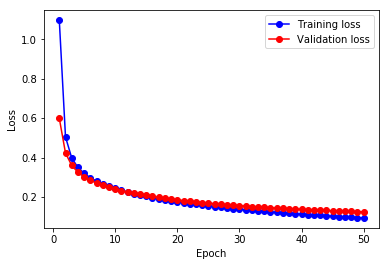

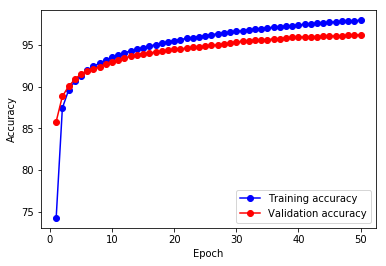

In [55]:
import matplotlib.pyplot as plt
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(ep_list, tr_loss_tot, 'bo-' ,label='Training loss')
plt.plot(ep_list, val_loss_tot, 'ro-',label = 'Validation loss')
plt.legend()
plt.show()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(ep_list, tr_acc_tot, 'bo-', label='Training accuracy')
plt.plot(ep_list, val_acc_tot, 'ro-' ,label = 'Validation accuracy')
plt.legend()
plt.show()